### Import thư viện và khai báo hằng số

In [1]:
import matplotlib.pyplot as plt
from torch import nn
import torch
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import tqdm
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score
import numpy as np
import math
from typing import Literal, Callable
import json
import biosig
import os
import random
import scipy.signal as signal
import time

In [2]:
device = 'cuda'
EVENT_TYPES = {
    "0x0114" : ("Idling EEG (eyes open)",276),
    "0x0115" : ("Idling EEG (eyes closed)",277),
    "0x0300" : ("Start of a trial",768),
    "0x0301" : ("Cue onset left (class 1)",769),
    "0x0302" : ("Cue onset right (class 2)",770),
    "0x0303" : ("Cue onset foot (class 3)",771),
    "0x0304" : (" Cue onset tongue (class 4)",772),
    "0x030d" : ("BCI feedback (continuous)",781),
    "0x030f" : ("Cue unknown",783),
    "0x03ff" : ("Rejected trial",1023),
    "0x0430" : ("Eye movements",1072),
    "0x0435" : ("Horizontal eye movement",1077),
    "0x0436" : ("Vertical eye movement",1078),
    "0x0437" : ("Eye rotation",1079),
    "0x0439" : ("Eye blinks",1081),
    "0x7ffe" : ("Start of a new run",32766)
}
SELECT_FEATURES = {
    "0x0301" : 0,
    "0x0302" : 1,
    "0x0303" : 2,
    "0x0304" : 3
}
BATCH_SIZE = 16
NUM_SAMPLES = 1000
SAMPLE_RATE = 250
CHANNELS = 22
OUTPUT_SIZE = len(SELECT_FEATURES)

### Định nghĩa mô hình

In [3]:
class EEGNet(nn.Module):
    def __init__(self, 
        channels: int = 22,
        sampling_rate: int = 250,
        signal_length: int = 100,
        dropout_rate: float = 0.5,
        f1: int = 8,
        D: int = 2,
        f2:int = 16,
        output_size: int = 1
    ):
        super(EEGNet, self).__init__()
        kernel_size_1 = (1, round(sampling_rate/2))
        kernel_size_2 = (channels, 1)
        kernel_size_3 = (1, round(sampling_rate/8))
        kernel_size_4 = (1, 1)
        kernel_avg_pool_1 = (1, 4)
        kernel_avg_poll_2 = (1, 8)
        kernel_padding_1 = "same"
        kernel_padding_3 = "same"
        # block 1 layer 1
        self.conv1 = nn.Conv2d(1, f1, kernel_size_1, padding=kernel_padding_1)
        self.bn1 = nn.BatchNorm2d(f1)
        # block 1 layer 2
        self.depth_wise_con1 = nn.Conv2d(f1, f1 * D, kernel_size_2, groups=1)
        self.bn2 = nn.BatchNorm2d(f1 * D)
        self.act1 = nn.ELU()
        self.avg_pool1 = nn.AvgPool2d(kernel_avg_pool_1)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        # block 2 layer 1
        self.separable_conv1_depth = nn.Conv2d(f1 * D, f1 * D, kernel_size_3,
                                               padding=kernel_padding_3, groups=f1*D)
        self.separable_conv1_point = nn.Conv2d(f1 * D, f2, kernel_size_4)
        self.bn3 = nn.BatchNorm2d(f2)
        self.act2 = nn.ELU()
        self.avg_pool2 = nn.AvgPool2d(kernel_avg_poll_2)
        # block 2 layer 2
        self.flatten = nn.Flatten()
        out_size = f2 * signal_length #// 4 # 8k
        # self.fc = nn.Sequential(
        #     nn.Linear(out_size, 1024), # 2k
        #     nn.LeakyReLU(0.25),
        #     nn.Linear(1024, 256), # 500
        #     nn.LeakyReLU(0.25),
        #     nn.Linear(256, 64), # 125
        #     nn.LeakyReLU(0.25),
        #     nn.Linear(64, output_size) # 2
        # )
        self.fc = nn.Linear(out_size, output_size)
        self.softmax = nn.Softmax(dim = 1)
    def forward(self, x: torch.Tensor):
        # block 1 layer 1
        x = self.bn1(self.conv1(x))
        # block 1 layer 2
        x = self.bn2(self.depth_wise_con1(x))
        x = self.act1(x)
        x = self.dropout1(self.avg_pool1(x))
        # block 2 layer 1
        x = self.separable_conv1_depth(x)
        x = self.bn3(self.separable_conv1_point(x))
        x = self.act2(x)
        # block 2 layer 2
        x = self.flatten(x)
        x = self.fc(x)
        # x = self.softmax(x)
        return x

#### Hàm hỗ trợ huấn luyện và kiểm tra

In [4]:
def train(model : nn.Module, dataloader : DataLoader, lossf : callable, optimizer : torch.optim.Optimizer):
    model.train()
    epoch_loss = 0
    count = 0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        inputs : torch.Tensor = inputs.permute(0,2,1).unsqueeze(1)
        # print(inputs.max(), inputs.min())
        inputs = torch.nan_to_num(inputs.float(), 0).to(device)
        labels : torch.Tensor = labels.to(device)
        # with torch.autocast(device_type=device, dtype=torch.bfloat16):
        outputs : torch.Tensor = model(inputs)
        # print(inputs.shape, outputs.shape, labels.shape)
        loss: torch.Tensor= lossf(outputs, labels)
        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        epoch_loss += loss.item()
        count += 1
    return epoch_loss/count
def test(model : nn.Module, dataloader : DataLoader, lossf : callable, ntag: int ):
    model.eval()
    epoch_loss = 0
    correct = 0
    count = 0
    total = 0
    precision_metric = MulticlassPrecision(num_classes=ntag, average='macro').to(device)
    recall_metric = MulticlassRecall(num_classes=ntag, average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=ntag, average='macro').to(device)
    for inputs, labels in dataloader:
        inputs : torch.Tensor = inputs.permute(0,2,1).unsqueeze(1)
        # [bsz, samples, channels] -> [bsz, channels, samples] -> [bsz, 1, channels, sample] , 1 is kernels
        inputs = torch.nan_to_num(inputs.float(), 0).to(device)
        labels : torch.Tensor = labels.to(device)
        # with torch.autocast(device_type=device, dtype=torch.bfloat16):
        outputs : torch.Tensor = model(inputs)
        loss: torch.Tensor= lossf(outputs, labels)
        epoch_loss += loss.item()
        predictions = torch.argmax(outputs, dim=-1)
        correct += (predictions == labels).sum().item()
        count += 1
        total += labels.size(0)
        precision_metric.update(predictions, labels)
        recall_metric.update(predictions, labels)
        f1_metric.update(predictions, labels)
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1_score = recall_metric.compute().item()
    return epoch_loss/count, correct / total , precision, recall, f1_score
def train_eval(trainloader : DataLoader, lossf: Callable, testloader : DataLoader, model : nn.Module, num_epochs : int,lr : float, gamma : float = 1, log_step : int = 5, warmup_step : int = 0, warmup_lr : float = 0.1, ntags: int =0):
    train_loader = trainloader
    test_loader = testloader
    optimizer = torch.optim.Adam(model.parameters(),lr=warmup_lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)
    model.to(device)
    print("Start train")
    train_losses = []
    test_losses = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []
    test_f1s = []
    for epoch in tqdm.trange(num_epochs):
        if (epoch == warmup_step):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        start_time = time.time_ns()
        train_losses.append(train(model, train_loader, lossf, optimizer))
        train_time = time.time_ns() - start_time
        start_time = time.time_ns()
        test_loss, test_accuracy, test_precision, test_recall, test_f1 = test(model, test_loader, lossf, ntags)
        test_time = time.time_ns() - start_time
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        test_precisions.append(test_precision)
        test_recalls.append(test_recall)
        test_f1s.append(test_f1)
        if (epoch >= warmup_step) : scheduler.step()
        if ((epoch + 1) % log_step == 0):
            log_str = f"Train time : {train_time/1e6} ms"
            log_str += f" Test time : {test_time/1e6} ms"
            log_str += f" Train loss : {train_losses[-1]:.4f}"
            log_str += f" Test loss : {test_losses[-1]:.4f}"
            log_str += f" Accuracy : {test_accuracies[-1]:.4f}"
            log_str += f" Precision : {test_precisions[-1]:.4f}"
            log_str += f" Recall : {test_recalls[-1]:.4f}"
            log_str += f" F1 : {test_f1s[-1]:.4f}"
            log_str += f" Lr: {scheduler.get_last_lr()[0]:.7f}"
            print(log_str)
    plt.figure(figsize=(10,3))
    plt.plot(train_losses, label = "Train loss", color = "blue")
    plt.plot(test_losses, label = "Test loss", color = "red")
    plt.legend()
    plt.figure(figsize=(10,3))
    plt.plot(test_accuracies, label= "Test accuracy", color = "blue")
    plt.plot(test_precisions, label= "Test precisions", color = "green")
    plt.plot(test_recalls, label = "Test recall", color="yellow")
    plt.plot(test_f1s, label = "Test f1", color="red")
    plt.legend()
    print("Complete")

### Đọc và xử lý dữ liệu

##### Filters

In [5]:
def low_pass_filter(data: np.ndarray, threshold: float = 0.5, sample_rate: int = 250, order: int = 4):
    b_low, a_low = signal.butter(order, threshold, btype='low', fs=sample_rate)
    low_passed = signal.filtfilt(b_low, a_low, data)
    return low_passed
def high_pass_filter(data: np.ndarray, threshold: float = 30, sample_rate: int = 250, order: int = 4):
    b_high, a_high = signal.butter(order, threshold, btype='high', fs=sample_rate)
    high_passed = signal.filtfilt(b_high, a_high, data)
    return high_passed

##### Đọc file

In [6]:
def read_gdf(file_path : str
            ) -> tuple[
                np.ndarray,
                dict[Literal["TYPE", "VERSION", "Filename", "NumberOfChannels", "NumberOfRecord", "SamplesPerRecored", "NumberOfSamples", "Samplingrate", "StartOfRecording", "TimezoneMinutesEastOfUTC", "NumberOfSweeps", "NumberOfGroupsOrUserSpecifiedEvents", "Patient"], object],
                list[dict[Literal['TYP', 'POS', 'DUR', 'Description'],object]],
                list[dict[Literal['ChannelNumber', 'Label', 'Samplingrate', 'Transducer', 'PhysicalMaximum', 'PhysicalMinimum', 'DigitalMaximum', 'DigitalMinimum', 'scaling', 'offset', 'Filter', 'Impedance', 'PhysicalUnit'], object]]
            ]:
    '''
    Return data, metadata, events data, channels data
    data : [n_t, n_channels],
    channel_data : [n_channels],
    events : [n_t, ...]
    '''
    header : dict[str, str | float, int , dict, object] = json.loads(biosig.header(file_path))
    data : np.ndarray = biosig.data(file_path)
    metadata = {
        "TYPE" : header["TYPE"],
        "VERSION" : header["VERSION"],
        "Filename" : header["Filename"],
        "NumberOfChannels" : header["NumberOfChannels"],
        "NumberOfRecord" : header["NumberOfRecords"],
        "SamplesPerRecored" : header["SamplesPerRecords"],
        "NumberOfSamples" : header["NumberOfSamples"],
        "Samplingrate" : header["Samplingrate"],
        "StartOfRecording" : header["StartOfRecording"],
        "TimezoneMinutesEastOfUTC" : header["TimezoneMinutesEastOfUTC"],
        "NumberOfSweeps" : header["NumberOfSweeps"],
        "NumberOfGroupsOrUserSpecifiedEvents" : header["NumberOfGroupsOrUserSpecifiedEvents"],
        "Patient" : header["Patient"]
    }
    channels = header["CHANNEL"]
    events = header["EVENT"]
    return data, metadata, events, channels

##### Class phụ để xử lý dữ liệu

In [7]:
class MotorImageryDataset(torch.utils.data.Dataset):
    def __init__(self, data: np.ndarray, event, metadata, item_length, selected_features: list[str], filters: list[Callable[[np.ndarray], np.ndarray]] = []):
        super().__init__()
        self.data: np.ndarray = np.nan_to_num(data.T, 0)
        for filter in filters:
            for i in range(len(self.data)):
                self.data[i] = filter(self.data[i])
        self.data = self.data.T
        self.event: list[tuple] = event
        self.metadata = metadata
        self.item_length = item_length
        self.index_mapper = {}
        self.selected_features = selected_features
        self.count = 0
        for index, value in enumerate(self.event):
            if value["TYP"] in self.selected_features:
                self.index_mapper[self.count] = index
                self.count += 1
    def __len__(self):
        return self.count
    '''
    [bsz, samples, channels]
    '''
    def __getitem__(self, index):
        real_index = self.index_mapper[index]
        event_id = self.selected_features[self.event[real_index]["TYP"]]
        data_start_it = math.floor(self.event[real_index]["POS"] * self.metadata["Samplingrate"])
        if (real_index + 1 < len(self.event)):
            data_end_it = math.ceil(self.event[real_index+1]["POS"] * self.metadata["Samplingrate"])
            event_data = self.data[data_start_it:data_end_it]
        else:
            event_data = self.data[data_start_it:]
        if event_data.shape[0] < self.item_length:
            event_data = np.pad(event_data, ((0, self.item_length - event_data.shape[0]), (0, 0)), mode='constant', constant_values=0)
        event_data = event_data[:self.item_length]
        return event_data, event_id

##### Hàm lấy về dataloader

In [8]:
def get_data_loader(
        select_features: dict[str, int],
        folder_path: str,
        n_workers: int,
        bsz: int,
        shuffle: bool = False,
        item_length: int = 1000,
        filters_: list[Callable[[np.ndarray], np.ndarray]] = []       
    ):
    dataset = []
    total_length = 0
    total_count = 0
    for file_name in os.listdir(folder_path):
        file_path =folder_path + "/" + file_name
        data, metadata, events, channels = read_gdf(file_path)
        dataset_ = MotorImageryDataset(data, events, metadata, item_length, select_features, filters_)
        total_length = len(data)
        total_count = len(events)
        for i in range(len(dataset_)):
            data, label = dataset_[i]
            dataset.append((data, label))
    dataset_size = len(dataset)
    random.shuffle(dataset)
    split_index = int(dataset_size * 0.9)
    train_dataset = dataset[:split_index]
    test_dataset = dataset[split_index:]
    train_loader = torch.utils.data.DataLoader(train_dataset, num_workers=n_workers, batch_size=bsz, shuffle=shuffle)
    test_loader = torch.utils.data.DataLoader(test_dataset, num_workers=n_workers, batch_size=bsz, shuffle=shuffle)
    return train_loader, test_loader, (len(train_dataset), len(test_dataset)), (total_length, total_count)


### Quá trình huấn luyện và đánh giá

#### Lấy dữ liệu

In [9]:
order = 4
def lowpass(data: np.ndarray):
    return low_pass_filter(data, 30, SAMPLE_RATE, order)
filters = [
    lowpass
]
trainloader, testloader, (train_length, test_length), _ = get_data_loader(
    select_features=SELECT_FEATURES, 
    folder_path="BCICIV_2a_gdf", 
    n_workers=0, 
    bsz=BATCH_SIZE,
    shuffle=True, 
    item_length=NUM_SAMPLES,
    filters_=filters
)
print("Train data count ",train_length)
print("Test data count ",test_length)

Train data count  2332
Test data count  260


##### Xem mẫu một vài dữ liệu

Label: 0


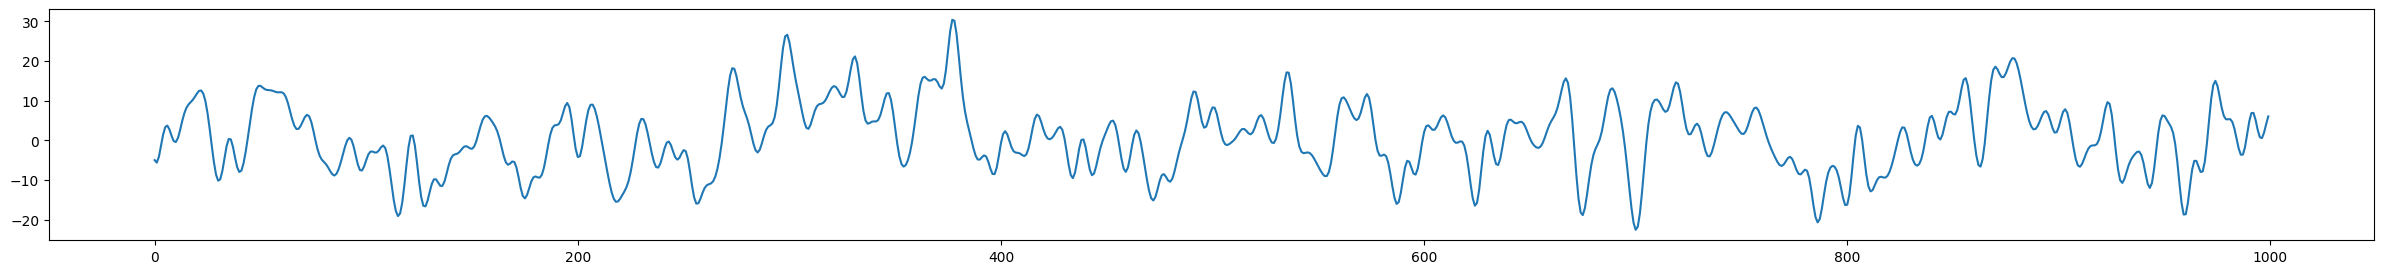

In [10]:
def sample_view(dataloader: torch.utils.data.DataLoader):
    input : torch.Tensor = None
    label : torch.Tensor = None
    for inputs, labels in dataloader:
        input = inputs[0]
        label = labels[0]
        break
    print(f"Label: {label}")
    plt.figure(figsize=(30,3))
    plt.plot(input.T[0])
sample_view(trainloader) # Dataloader trainloader để random nên mỗi lần chạy sẽ khác nhau

#### Khai báo mô hình

In [11]:
model = EEGNet(
    channels=CHANNELS,
    sampling_rate=250,
    signal_length=NUM_SAMPLES,
    output_size=OUTPUT_SIZE,
    f1=8,
    D=2,
    f2=16,
    dropout_rate=0.5
)
lossf = nn.CrossEntropyLoss()

#### Train và evaluate mô hình

Start train


 10%|█         | 3/30 [00:04<00:34,  1.29s/it]

Train time : 1082.8252 ms Test time : 93.9428 ms Train loss : 0.8780 Test loss : 0.8984 Accuracy : 0.6269 Precision : 0.6351 Recall : 0.6259 F1 : 0.6259 Lr: 0.0000913


 20%|██        | 6/30 [00:07<00:29,  1.21s/it]

Train time : 1086.6505 ms Test time : 98.099 ms Train loss : 0.6757 Test loss : 0.8892 Accuracy : 0.6269 Precision : 0.6394 Recall : 0.6266 F1 : 0.6266 Lr: 0.0000833


 30%|███       | 9/30 [00:11<00:24,  1.19s/it]

Train time : 1078.8403 ms Test time : 98.8288 ms Train loss : 0.5527 Test loss : 0.8637 Accuracy : 0.6769 Precision : 0.6808 Recall : 0.6769 F1 : 0.6769 Lr: 0.0000760


 40%|████      | 12/30 [00:14<00:21,  1.19s/it]

Train time : 1085.9771 ms Test time : 99.1112 ms Train loss : 0.4683 Test loss : 0.8558 Accuracy : 0.6846 Precision : 0.6956 Recall : 0.6844 F1 : 0.6844 Lr: 0.0000694


 50%|█████     | 15/30 [00:18<00:17,  1.19s/it]

Train time : 1095.4068 ms Test time : 99.0972 ms Train loss : 0.4153 Test loss : 0.8767 Accuracy : 0.6692 Precision : 0.6785 Recall : 0.6687 F1 : 0.6687 Lr: 0.0000633


 60%|██████    | 18/30 [00:21<00:14,  1.20s/it]

Train time : 1109.3465 ms Test time : 109.5888 ms Train loss : 0.3770 Test loss : 0.9152 Accuracy : 0.6654 Precision : 0.6837 Recall : 0.6653 F1 : 0.6653 Lr: 0.0000578


 70%|███████   | 21/30 [00:25<00:10,  1.20s/it]

Train time : 1101.2554 ms Test time : 106.0223 ms Train loss : 0.3368 Test loss : 0.9285 Accuracy : 0.6500 Precision : 0.6631 Recall : 0.6497 F1 : 0.6497 Lr: 0.0000527


 80%|████████  | 24/30 [00:29<00:07,  1.20s/it]

Train time : 1094.3994 ms Test time : 93.1982 ms Train loss : 0.3091 Test loss : 0.9670 Accuracy : 0.6462 Precision : 0.6612 Recall : 0.6458 F1 : 0.6458 Lr: 0.0000481


 90%|█████████ | 27/30 [00:32<00:03,  1.20s/it]

Train time : 1103.0898 ms Test time : 100.6656 ms Train loss : 0.2623 Test loss : 0.9063 Accuracy : 0.6731 Precision : 0.6832 Recall : 0.6727 F1 : 0.6727 Lr: 0.0000439


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]

Train time : 1087.932 ms Test time : 96.209 ms Train loss : 0.2639 Test loss : 0.9127 Accuracy : 0.6692 Precision : 0.6855 Recall : 0.6692 F1 : 0.6692 Lr: 0.0000401
Complete


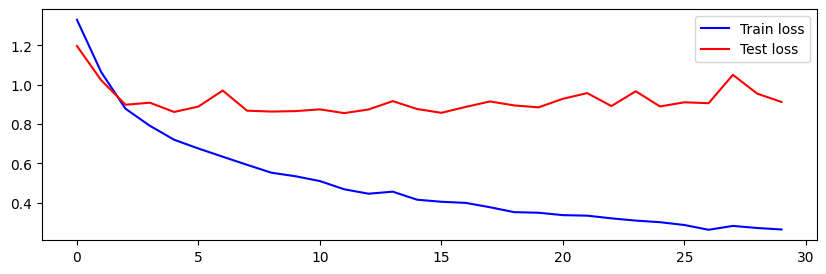

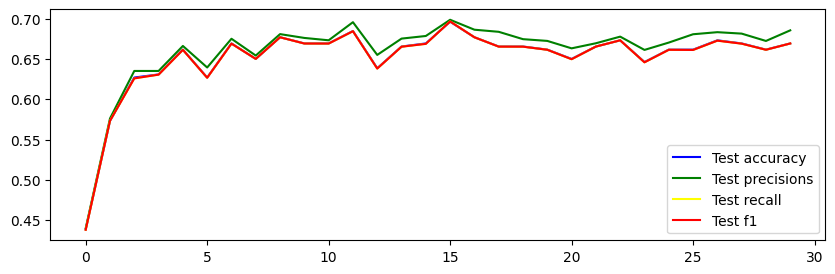

In [12]:
train_eval(
    trainloader=trainloader,
    testloader=testloader,
    model=model,
    lossf=lossf,
    num_epochs=30,
    lr=1e-4,
    gamma=0.97,
    log_step=3,
    warmup_step=0,
    warmup_lr=0,
    ntags=OUTPUT_SIZE
)